# LowpolyPy

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import cv2
import gizeh
import numpy as np
import matplotlib.pyplot as plt
import skimage.draw
from pathlib import Path
from IPython.display import display
from scipy.spatial import cKDTree, Delaunay
from scipy import signal
from PIL import Image, ImageDraw, ImageColor
from abc import ABCMeta, abstractmethod
from typing import List, Callable
from dataclasses import dataclass, replace

import torch
from torch import nn
from torch.nn import functional as F
import torchvision

import shapely
from shapely.ops import triangulate
from shapely.geometry import box, Point, LineString, Polygon, MultiPoint, MultiPolygon, asMultiPoint

### The 3-part Lowpolyfication System

- **Point Generation**: Given an image, generate a set of points
- **Polygon Generation**: Given an image and a set of points, generate a set of polygons
- **Shading**: Given an image and a set of polygons, shade the image to get a low-poly image

The cell below defines the base classes for each of these components

In [2]:
@dataclass(frozen=True, order=False)
class ComponentData:
    image: torch.Tensor = None
    points: torch.Tensor = None
    polygons: torch.Tensor = None
#     previous: "ComponentData" = None

In [3]:
class RandomPoints(nn.Module):
    def __init__(self, num_points=100):
        super().__init__()
        self.num_points = num_points

    def forward(self, data):
        image = data.image
        assert image.ndim == 4, "image must be a batched tensor of shape (batch, channels, height, width)"
        batch_size, channels, height, width = image.shape
        points = torch.rand(batch_size, self.num_points, 2, device=image.device)
        points = torch.round(points * torch.tensor([[[width, height]]], device=points.device))
        return points


class PruneClosePoints(nn.Module):
    def __init__(self, min_dist=8):
        super().__init__()
        self.min_dist = min_dist

    def forward(self, data):
        points = data.points
        assert points.ndim == 3, "points must be a 3d tensor of shape (batch, num_points, num_dims)"
        batch_size, num_points, num_dims = points.shape
        # Construct matrices of point coordinates
        x = points.unsqueeze(1).expand(-1, num_points, num_points, num_dims)
        y = points.unsqueeze(2).expand(-1, num_points, num_points, num_dims)
        # Compute pair-wise point distances
        distances = (x - y).pow(2).sum(-1)
        # Find non-identical point pairs where distance < threshold
        close = torch.nonzero((distances < self.min_dist).triu())
        close = close[close[:, 1] != close[:, 2]]
        # Mark one point from each close point pair as 'invalid' (i.e. -1)
        to_remove = close[:, :2].unique(dim=0)
        pruned_points = points.clone()
        pruned_points[to_remove[:, 0], to_remove[:, 1]] = -1
        return pruned_points


class AddCornerPoints(nn.Module):
    def forward(self, data):
        points, image = data.points, data.image
        assert len(image) == len(points), "'points' and 'image' must have the same batch size"
        batch_size, num_points, num_dims = points.shape
        _, channels, height, width = image.shape
        corners = torch.tensor([[0, 0], [width, 0], [0, height], [width, height]], device=points.device, dtype=points.dtype).unsqueeze(0).expand(batch_size, -1, -1)
        new_points = torch.cat((points, corners), dim=1)
        return new_points


class DelaunayTriangulator(nn.Module):
    def forward(self, data):
        points = data.points
        # TODO: remove zero-pixel area triangles: https://www.nctm.org/tmf/library/drmath/view/55169.html
        # TODO: Port Triangulation to PyTorch?
        assert points.ndim == 3, "points must be a 3d tensor of shape (batch, num_points, num_dims)"
        batch_size, num_points, num_dims = points.shape
        batch_polygons = []
        for p in points:
            valid_indices = torch.nonzero(p >= 0)
            p = p[valid_indices[:, 0]]
            delaunay = Delaunay(p.cpu().detach())
            batch_polygons.append(p[delaunay.simplices])
        max_polygons = max(len(polygons) for polygons in batch_polygons)
        polygons_tensor = torch.zeros(batch_size, max_polygons, 3, num_dims)
        for i, polygons in enumerate(batch_polygons):
            polygons_tensor[i, :len(polygons)] = polygons
        return polygons_tensor


class MeanShader(nn.Module):
    def forward(self, data):
        image, polygons = data.image, data.polygons
        # TODO: Compute this with PyTorch via intersection of masks of signed distances of each point from each polygon edge
        # https://diygpu.wordpress.com/author/akismetuser496448491/
        assert len(image) == len(polygons), "'polygons' and 'image' must have the same batch size"
        batch_size, channels, height, width = image.shape
        shaded = image.detach().clone().cpu().numpy()
        surface = gizeh.Surface(width=width, height=height)
        for i, (img, polys) in enumerate(zip(image, polygons)):
            img = img.permute(1, 2, 0).detach().cpu().numpy()
            mask = np.zeros((height, width), dtype=np.uint8)
            # TODO: Port polygon rasterization to PyTorch
            for p in polys.detach().cpu().numpy():
                cv2.fillConvexPoly(mask, p.astype(np.int32), 255)
                nonzero = mask.nonzero()
                pixels = img[nonzero]
                if pixels.size == 0:
                    continue
                mean_color = pixels.mean(0)
                gizeh.polyline(p, fill=mean_color[::-1]).draw(surface)
#                 shaded[i, :, nonzero[0], nonzero[1]] = mean_color
                mask[:] = 0
#                 break
            shaded[i] = surface.get_npimage().transpose(2, 0, 1)
        shaded = torch.from_numpy(shaded).to(image.device)
        return shaded

In [4]:
class Lowpoly(nn.Module):
    def __init__(self, num_points=1000, min_dist=8):
        super().__init__()
        self.num_points = num_points
        self.min_dist = min_dist

    def forward(self, image: torch.Tensor):
        points = self.random_points(image)
        points = self.prune_close_points(points)
        points = self.add_corner_points(points, image)
        polygons = self.triangluate(points)
        shaded = self.shade_mean(image, polygons)
        return points, polygons, shaded

    def random_points(self, image: torch.Tensor):
        assert image.ndim == 4, "image must be a batched tensor of shape (batch, channels, height, width)"
        batch_size, channels, height, width = image.shape
        points = torch.rand(batch_size, self.num_points, 2, device=image.device)
        points = torch.round(points * torch.tensor([[[width, height]]], device=points.device))
        return points

    def prune_close_points(self, points: torch.Tensor):
        assert points.ndim == 3, "points must be a 3d tensor of shape (batch, num_points, num_dims)"
        batch_size, num_points, num_dims = points.shape
        # Construct matrices of point coordinates
        x = points.unsqueeze(1).expand(-1, num_points, num_points, num_dims)
        y = points.unsqueeze(2).expand(-1, num_points, num_points, num_dims)
        # Compute pair-wise point distances
        distances = (x - y).pow(2).sum(-1)
        # Find non-identical point pairs where distance < threshold
        close = torch.nonzero((distances < self.min_dist).triu())
        close = close[close[:, 1] != close[:, 2]]
        # Mark one point from each close point pair as 'invalid' (i.e. -1)
        to_remove = close[:, :2].unique(dim=0)
        pruned_points = points.clone()
        pruned_points[to_remove[:, 0], to_remove[:, 1]] = -1
        return pruned_points

    def add_corner_points(self, points: torch.Tensor, image: torch.Tensor):
        assert len(image) == len(points), "'points' and 'image' must have the same batch size"
        batch_size, num_points, num_dims = points.shape
        _, channels, height, width = image.shape
        corners = torch.tensor([[0, 0], [width, 0], [0, height], [width, height]], device=points.device, dtype=points.dtype).unsqueeze(0).expand(batch_size, -1, -1)
        new_points = torch.cat((points, corners), dim=1)
        return new_points

    def triangluate(self, points: torch.Tensor):
        # TODO: remove zero-pixel area triangles: https://www.nctm.org/tmf/library/drmath/view/55169.html
        # TODO: Port Triangulation to PyTorch?
        assert points.ndim == 3, "points must be a 3d tensor of shape (batch, num_points, num_dims)"
        batch_size, num_points, num_dims = points.shape
        batch_polygons = []
        for p in points:
            valid_indices = torch.nonzero(p >= 0)
            p = p[valid_indices[:, 0]]
            delaunay = Delaunay(p.cpu().detach())
            batch_polygons.append(p[delaunay.simplices])
        max_polygons = max(len(polygons) for polygons in batch_polygons)
        polygons_tensor = torch.zeros(batch_size, max_polygons, 3, num_dims)
        for i, polygons in enumerate(batch_polygons):
            polygons_tensor[i, :len(polygons)] = polygons
        return polygons_tensor

    def shade_mean(self, image: torch.Tensor, polygons: torch.Tensor):
        assert len(image) == len(polygons), "'polygons' and 'image' must have the same batch size"
        batch_size, channels, height, width = image.shape
        shaded = image.detach().clone().cpu().numpy()
        surface = gizeh.Surface(width=width, height=height)
        for i, (img, polys) in enumerate(zip(image, polygons)):
            img = img.permute(1, 2, 0).detach().cpu().numpy()
            mask = np.zeros((height, width), dtype=np.uint8)
            # TODO: Speed up polygon rasterization by porting to PyTorch?
            for p in polys.detach().cpu().numpy():
                cv2.fillConvexPoly(mask, p.astype(np.int32), 255)
                nonzero = mask.astype(np.bool)
                if not nonzero.any():
                    continue
                nonzero = mask.nonzero()
                pixels = img[nonzero]
                if pixels.size == 0:
                    continue
                mean_color = pixels.mean(0)
                gizeh.polyline(p, fill=(1 - mean_color).tolist(), stroke=None).draw(surface)

#                 shaded[i, :, nonzero[0], nonzero[1]] = mean_color
                mask.fill(0)
            shaded[i] = surface.get_npimage().transpose(2, 0, 1)
        shaded = torch.from_numpy(shaded).to(image.device)
        return shaded

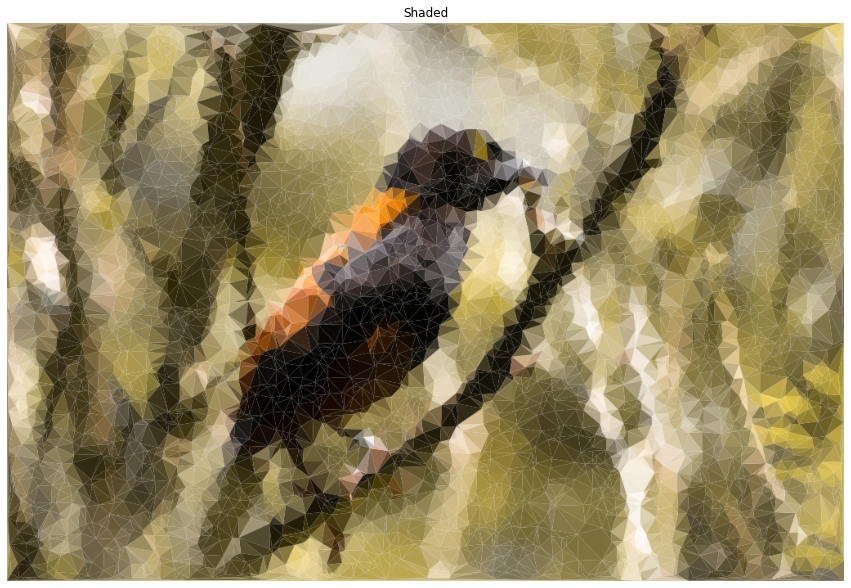

         698619 function calls (697314 primitive calls) in 34.388 seconds

   Ordered by: internal time
   List reduced from 1313 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     9243   29.120    0.003   29.120    0.003 {method 'nonzero' of 'numpy.ndarray' objects}
    18502    2.309    0.000    2.309    0.000 {method 'astype' of 'numpy.ndarray' objects}
    18768    0.467    0.000    0.467    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.284    0.284   33.511   33.511 <ipython-input-4-b1f2bdf58c77>:64(shade_mean)
     9241    0.256    0.000    0.393    0.000 _methods.py:143(_mean)
     9241    0.158    0.000    0.158    0.000 {method 'fill' of 'numpy.ndarray' objects}
     9241    0.131    0.000    0.152    0.000 twodim_base.py:152(eye)
       78    0.122    0.002    0.122    0.002 {method 'encode' of 'ImagingEncoder' objects}
        1    0.102    0.102    0.355    0.355 <ipython-input-4-b1f2bdf58c77>:22(pru

In [6]:
%%prun -l 30
BATCH_SIZE = 1
DEVICE = "cpu"

IMAGE_PATH = "../images/bird1.jpg"
image = Image.open(IMAGE_PATH)
image.thumbnail((1024, 1024))
# plt.figure(figsize=(15, 15))
# plt.title("Original")
# plt.imshow(image)
# plt.axis("off")
# plt.show()

image = torchvision.transforms.functional.to_tensor(image)
image = image.to(DEVICE)
image = image.expand(BATCH_SIZE, -1, -1, -1)
# image = [image for _ in range(BATCH_SIZE)]

# data = ComponentData(image=image)
# random_point_generator = RandomPoints(num_points=1000)
# point_min_distance = PruneClosePoints(4)
# delaunay_triangulator = DelaunayTriangulator()
# mean_shader = MeanShader()
# kmeans_shader = KmeansShader()
# conv_point_generator = ConvPoints(num_points=5000, num_filler_points=500)
# pipeline = nn.Sequential(
#     random_point_generator,
#     point_min_distance,
# )
# data = pipeline(data)

pipeline = Lowpoly(num_points=5000)
pipeline.to(DEVICE)
points, polygons, shaded = pipeline(image)
shaded = torchvision.transforms.functional.to_pil_image(shaded[0])
plt.figure(figsize=(15, 15))
plt.title("Shaded")
plt.imshow(shaded)
plt.axis("off")
plt.show()

# safe_indices = torch.ones(points.shape[:-1], dtype=torch.bool, device=points.device)
# safe_indices[unsafe_indices] = 0
# safe_coordinates = points[safe_indices]
# safe_coordinates
# neighbors = {}
# for i, j in close_pairs:
#     neighbors.setdefault(i, set()).add(j)
#     neighbors.setdefault(j, set()).add(i)
# discard = set()
# keep = []
# for node in range(len(points)):
#     if node not in discard:
#         keep.append(node)
#         discard.update(neighbors.get(node, set()))
# points = [p for i, p in enumerate(points) if i not in discard]

# rand_data = random_point_generator(data)
# rand_data = delaunay_triangulator(rand_data)
# rand_data = kmeans_shader(rand_data)
# plt.figure(figsize=(15, 15))
# plt.title("Random Points")
# plt.imshow(rand_data.image)
# plt.axis("off")
# plt.show()

# conv_data = conv_point_generator(data)
# conv_data = delaunay_triangulator(conv_data)
# conv_data = kmeans_shader(conv_data)
# plt.figure(figsize=(15, 15))
# plt.title("Conv Points")
# plt.imshow(conv_data.image)
# plt.axis("off")
# plt.show()

# TODO: Add loss method to PointGenerator for optimization
# loss = conv_points.get_loss(image, lowpoly)

## Batched close-point removal

In [230]:
thresh = 4
batch, n, d = points.shape
x = points.unsqueeze(1).expand(-1, n, n, d)
y = points.unsqueeze(2).expand(-1, n, n, d)
distances = (x - y).pow(2).sum(-1)
close = torch.nonzero((distances < thresh).triu())
close = close[close[:, 1] != close[:, 2]]

safe = torch.ones((batch, n), dtype=torch.bool, device=points.device)
unsafe = close[:, :2].unique(dim=0)
safe[unsafe[:, 0], unsafe[:, 1]] = 0
_, num_unsafe = unsafe[:, 0].unique_consecutive(return_counts=True, dim=0)
unrolled = [F.pad(points[i, s], (0, 0, 0, num_unsafe[i]), value=-1) for i, s in enumerate(safe)]
new_points = torch.stack(unrolled)

num_invalid = torch.count_nonzero(new_points[..., 0] == -1, dim=1)

tensor([ 7,  5, 12,  9])

# Legacy code

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.draw
from pathlib import Path
from IPython.display import display
from scipy.spatial import cKDTree
from scipy import signal
from PIL import Image, ImageDraw, ImageColor
from abc import ABCMeta, abstractmethod
from typing import List, Callable
from dataclasses import dataclass, replace

import torch
from torch import nn
from torch.nn import functional as F

import shapely
from shapely.ops import triangulate
from shapely.geometry import box, Point, LineString, Polygon, MultiPoint, MultiPolygon, asMultiPoint

In [66]:
class PipelineComponent(nn.Module, metaclass=ABCMeta):
    forward: Callable[[ComponentData], ComponentData]

In [23]:
class PointGenerator(PipelineComponent):
    """
    Takes in a PIL image and returns a list of normalized shapely points
    """
    def __call__(self, data):
        input_image = data.image
        new_data = super().__call__(data)
        points = new_data.points
        points = self.rescale_points(points, input_image.size)  # TODO: Remove redundant rescaling
        points = self.remove_duplicates(points, 4)
        points = self.with_boundary_points(points, input_image.size)
        return replace(new_data, points=points)

    @staticmethod
    def rescale_points(points, image_size):
        """
        Rescales [0, 1] normalized points to the specified Width x Height.
        """
        coordinates = (np.array([p.xy for p in points]).squeeze(-1) * image_size).round()
        return list(asMultiPoint(coordinates))

    @staticmethod
    def with_boundary_points(points, image_size):
        edge_box = box(0, 0, *image_size)
        edges = edge_box.exterior

        edge_points = []
        hull = shapely.ops.unary_union(points).convex_hull
        hull_points = [Point(c) for c in hull.exterior.coords]
        edge_points = [edges.interpolate(edges.project(p)) for p in hull_points]

        corners = [Point(c) for c in edges.coords[:-1]]

        return points + edge_points + corners

    @staticmethod
    def remove_duplicates(points, tolerance):
        # TODO: Port to PyTorch using pairwise distance: https://pytorch.org/docs/stable/generated/torch.cdist.html
        coordinates = np.array([p.xy for p in points]).squeeze(-1)

        tree = cKDTree(coordinates, compact_nodes=len(points) > 1000)
        close_pairs = tree.query_pairs(r=tolerance, output_type="ndarray")

        unsafe_indices = np.unique(close_pairs)
        safe_indices = np.ones(len(points), dtype=np.bool)
        safe_indices[unsafe_indices] = 0
        safe_coordinates = coordinates[safe_indices]

        neighbors = {}
        for i, j in close_pairs:
            neighbors.setdefault(i, set()).add(j)
            neighbors.setdefault(j, set()).add(i)
        discard = set()
        keep = []
        for node in range(len(points)):
            if node not in discard:
                keep.append(node)
                discard.update(neighbors.get(node, set()))
        points = [p for i, p in enumerate(points) if i not in discard]
        return points


class Polygonizer(PipelineComponent):
    """
    Takes in a PIL Image and (optionally) a list of shapely points and returns a list of shapely polygons.
    Output should be independent of the order of points.
    """
    def __call__(self, data):
        new_data = super().__call__(data)
        polygons = new_data.polygons
        polygons = self.simplify(polygons)
        return replace(new_data, polygons=polygons)

    @staticmethod
    def simplify(polygons):
        # TODO: Merge small polygons
        return polygons


class Shader(PipelineComponent):
    """
    Takes in a PIL image and (optionally) a list of points and (optionally) a list of polygons and returns a shaded image.
    Output should be invariant to the order of points or polygons.
    """
#     def __call__(self, data):
#         return super()(data)

In [24]:
class RandomPoints(PointGenerator):
    def __init__(self, num_points=100):
        super().__init__()
        self.num_points = num_points

    def forward(self, data):
#         image = data.image
        coordinates = np.random.rand(self.num_points, 2)
        points = [Point(c) for c in coordinates]
        return replace(data, points=points)


class ConvPoints(PointGenerator):
    def __init__(self, num_points=1000, num_filler_points=50, weight_filler_points=True):
        super().__init__()
        self.num_points = num_points
        self.num_filler_points = num_filler_points
        self.weight_filler_points = weight_filler_points

    def forward(self, data):
        image = data.image
        points = []

        image = np.array(image)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        kernel = np.array([
            [ -3-3j, 0-10j,  +3 -3j],
            [-10+0j, 0+ 0j, +10 +0j],
            [ -3+3j, 0+10j,  +3 +3j],
        ])
        grad = signal.convolve2d(gray, kernel, boundary='symm', mode='same')
        mag = np.absolute(grad)
        mag = mag / mag.max()
        mag[mag <= 0.1] = 0
        mag = cv2.equalizeHist((mag * 255).astype(np.uint8))
        weights = np.ravel(mag.astype(np.float32) / mag.sum())
        coordinates = np.arange(0, weights.size, dtype=np.uint32)
        choices = np.random.choice(coordinates, size=self.num_points, replace=False, p=weights)
        raw_points = np.unravel_index(choices, image.shape[:2])
        conv_points = np.stack(raw_points, axis=-1) / image.shape[:2]
        points += list(MultiPoint(conv_points[..., ::-1]))

        if self.num_filler_points:
            inverse = 255 - cv2.dilate(mag, np.ones((5, 5), np.uint8), iterations=3)
            inverse = cv2.blur(inverse, ksize=(13, 13)).astype(np.float64)
            weights = np.ravel(inverse / inverse.sum())
            print(weights, weights.sum())
            coordinates = np.arange(0, weights.size, dtype=np.uint32)
            choices = np.random.choice(coordinates, size=self.num_filler_points, replace=False, p=weights if self.weight_filler_points else None)
            raw_points = np.unravel_index(choices, image.shape[:2])
            filler_points = np.stack(raw_points, axis=-1) / image.shape[:2]
            points += list(MultiPoint(filler_points[..., ::-1]))

        return replace(data, points=points)


class DelaunayTriangulator(Polygonizer):
    def __init__(self):
        super().__init__()

    def forward(self, data):
        points = data.points
        if not isinstance(points, MultiPoint):
            points = MultiPoint(points)
        triangles = triangulate(points)
        return replace(data, polygons=triangles)


class MeanShader(Shader):
    def __init__(self):
        super().__init__()

    def forward(self, data):
        image, points, polygons = data.image, data.points, data.polygons
        image = np.array(image)
        shaded = np.array(image)
        mask = np.zeros((*image.shape[:2], 1), dtype=np.uint8)
        for polygon in polygons:
            coords = np.array(polygon.exterior.coords)
            mask[:] = 0
            cv2.fillPoly(mask, [(coords * 256).astype(np.int32)], 255, shift=8)
            mean_color = np.array(cv2.mean(image, mask=mask)[:3], dtype=np.uint8)
            cv2.fillPoly(shaded, [(coords * 256).astype(int)], mean_color.tolist(), lineType=cv2.LINE_AA, shift=8)
        return replace(data, image=Image.fromarray(shaded))


class KmeansShader(Shader):
    def __init__(self, num_clusters=3, num_attempts=3):
        super().__init__()
        self.num_clusters = num_clusters
        self.num_attempts = num_attempts

    @staticmethod
    def get_dominant_color(pixels, num_clusters, attempts):
        """
        Given a (N, Channels) array of pixel values, compute the dominant color via K-means
        """
        if len(pixels) == 1:
            return pixels[0]
        num_clusters = min(num_clusters, len(pixels))
        flags = cv2.KMEANS_RANDOM_CENTERS
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_MAX_ITER, 1, 10)
        _, labels, centroids = cv2.kmeans(pixels.astype(np.float32), num_clusters, None, criteria, attempts, flags)
        _, counts = np.unique(labels, return_counts=True)
        dominant = centroids[np.argmax(counts)]
        return dominant

    def forward(self, data):
        image, points, polygons = data.image, data.points, data.polygons
        image = np.array(image)
        shaded = np.zeros_like(image)
        for polygon in polygons:
            coords = np.array(polygon.exterior.coords)
            rr, cc = skimage.draw.polygon(*coords.T[::-1])
            region = image[rr, cc]
            if len(region) == 0:
                continue
            mean_color = self.get_dominant_color(region, self.num_clusters, self.num_attempts)
            cv2.fillPoly(shaded, [(coords * 256).astype(int)], mean_color.tolist(), lineType=cv2.LINE_AA, shift=8)
        return replace(data, image=Image.fromarray(shaded))

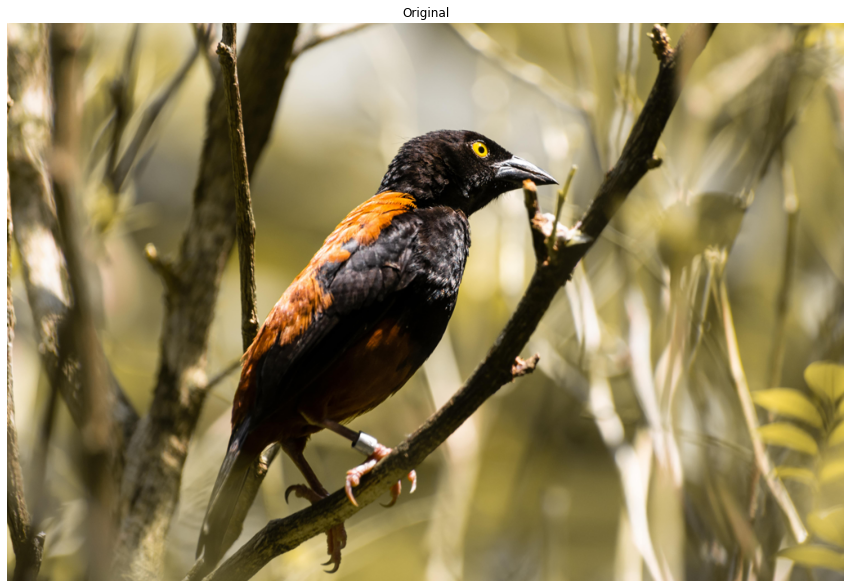

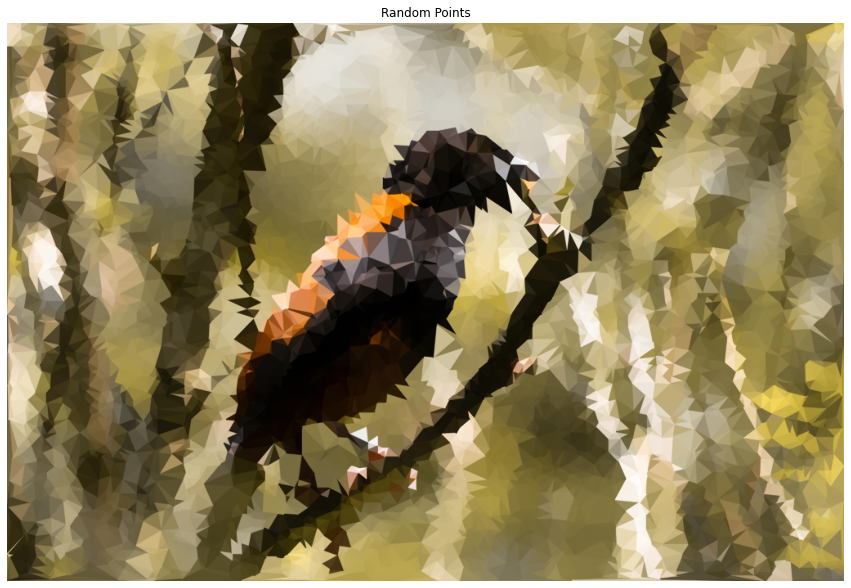

In [25]:
# %%prun -l 30
IMAGE_PATH = "../images/bird1.jpg"
image = Image.open(IMAGE_PATH)
image.thumbnail((1024, 1024))

plt.figure(figsize=(15, 15))
plt.title("Original")
plt.imshow(image)
plt.axis("off")
plt.show()

data = ComponentData(image=image)

random_point_generator = RandomPoints(num_points=5000)
conv_point_generator = ConvPoints(num_points=5000, num_filler_points=500)
delaunay_triangulator = DelaunayTriangulator()
kmeans_shader = KmeansShader()

rand_data = random_point_generator(data)
rand_data = delaunay_triangulator(rand_data)
rand_data = kmeans_shader(rand_data)
plt.figure(figsize=(15, 15))
plt.title("Random Points")
plt.imshow(rand_data.image)
plt.axis("off")
plt.show()

# conv_data = conv_point_generator(data)
# conv_data = delaunay_triangulator(conv_data)
# conv_data = kmeans_shader(conv_data)
# plt.figure(figsize=(15, 15))
# plt.title("Conv Points")
# plt.imshow(conv_data.image)
# plt.axis("off")
# plt.show()

# TODO: Add loss method to PointGenerator for optimization
# loss = conv_points.get_loss(image, lowpoly)